# MoE vs Dense Scaling Laws Analysis

This notebook compares training curves of Mixture of Experts (MoE) models versus Dense models.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.facecolor'] = 'white'

In [13]:
# Load the data
df = pd.read_csv('/Users/timur/Desktop/Relace/wandb_friday/moe_analysis/wandb_export_2026-01-16T16_15_57.336-08_00.csv')
print(f"Data shape: {df.shape}")

model_names = set()
for col in df.columns:
    if ' - ' in col:
        model_names.add(col.split(' - ')[0])

print("\nFound models:")
for name in sorted(model_names):
    print(f"  - {name}")

Data shape: (37536, 91)

Found models:
  - saturate_135M_15B_03
  - saturate_1B_15B.py
  - saturate_2.5M_15B
  - saturate_271M_15B_2
  - saturate_271M_15_2_cont
  - saturate_30M_15B
  - saturate_3B_15B
  - saturate_60M_15B
  - saturate_moe1Bolmo_15B
  - saturate_moe1Bsparse_15B
  - saturate_moe3BA100M_15B
  - saturate_moe3BA1B_15B
  - saturate_moe3BA300M_15B
  - saturate_moe60MA24M_15B
  - saturate_moe60MA6M_15B


In [14]:
# Model metadata
MODEL_INFO = {
    # Dense models
    'saturate_2.5M_15B': {'display_name': 'Dense 2.5M', 'total_params': 2.5e6, 'active_params': 2.5e6, 'is_moe': False, 'total_group': 'other', 'active_group': 'tiny'},
    'saturate_30M_15B': {'display_name': 'Dense 30M', 'total_params': 30e6, 'active_params': 30e6, 'is_moe': False, 'total_group': 'other', 'active_group': 'small'},
    'saturate_60M_15B': {'display_name': 'Dense 60M', 'total_params': 60e6, 'active_params': 60e6, 'is_moe': False, 'total_group': '60M', 'active_group': 'other'},
    'saturate_135M_15B_03': {'display_name': 'Dense 135M', 'total_params': 135e6, 'active_params': 135e6, 'is_moe': False, 'total_group': 'other', 'active_group': 'medium'},
    'saturate_271M_15B_2': {'display_name': 'Dense 271M', 'total_params': 271e6, 'active_params': 271e6, 'is_moe': False, 'total_group': 'other', 'active_group': 'large'},
    'saturate_271M_15_2_cont': {'display_name': 'Dense 271M (cont)', 'total_params': 271e6, 'active_params': 271e6, 'is_moe': False, 'total_group': 'other', 'active_group': 'large'},
    '271M': {'display_name': 'Dense 271M', 'total_params': 271e6, 'active_params': 271e6, 'is_moe': False, 'total_group': 'other', 'active_group': 'large'},
    'saturate_1B_15B.py': {'display_name': 'Dense 1B', 'total_params': 1e9, 'active_params': 1e9, 'is_moe': False, 'total_group': '1B', 'active_group': 'other'},
    'saturate_3B_15B': {'display_name': 'Dense 3B', 'total_params': 3e9, 'active_params': 3e9, 'is_moe': False, 'total_group': '3B', 'active_group': 'other'},
    # MoE 60M total
    'saturate_moe60MA24M_15B': {'display_name': 'MoE 60M (A:24M)', 'total_params': 60e6, 'active_params': 24e6, 'is_moe': True, 'total_group': '60M', 'active_group': 'small'},
    'saturate_moe60MA6M_15B': {'display_name': 'MoE 60M (A:6M)', 'total_params': 60e6, 'active_params': 6e6, 'is_moe': True, 'total_group': '60M', 'active_group': 'tiny'},
    # MoE 1B total
    'saturate_moe1Bsparse_15B': {'display_name': 'MoE 1B (A:115M)', 'total_params': 1e9, 'active_params': 115e6, 'is_moe': True, 'total_group': '1B', 'active_group': 'medium'},
    'saturate_moe1Bolmo_15B': {'display_name': 'MoE 1B (A:390M)', 'total_params': 1e9, 'active_params': 390e6, 'is_moe': True, 'total_group': '1B', 'active_group': 'large'},
    # MoE 3B total
    'saturate_moe3BA1B_15B': {'display_name': 'MoE 3B (A:1B)', 'total_params': 3e9, 'active_params': 1e9, 'is_moe': True, 'total_group': '3B', 'active_group': 'other'},
    'saturate_moe3BA300M_15B': {'display_name': 'MoE 3B (A:300M)', 'total_params': 3e9, 'active_params': 300e6, 'is_moe': True, 'total_group': '3B', 'active_group': 'large'},
    'saturate_moe3BA100M_15B': {'display_name': 'MoE 3B (A:100M)', 'total_params': 3e9, 'active_params': 100e6, 'is_moe': True, 'total_group': '3B', 'active_group': 'medium'},
}

def format_params(n):
    if n >= 1e9: return f"{n/1e9:.1f}B"
    elif n >= 1e6: return f"{n/1e6:.0f}M"
    elif n >= 1e3: return f"{n/1e3:.0f}K"
    return str(int(n))

def get_sparsity(name):
    info = MODEL_INFO.get(name, {})
    total = info.get('total_params', 1)
    active = info.get('active_params', 1)
    return active / total  # 1.0 = dense, <1 = sparse

In [15]:
def extract_model_data(df, model_name):
    loss_col = f"{model_name} - train/CE loss"
    step_col = f"{model_name} - _step"
    pf_col = "throughput/total petaflops"
    if loss_col not in df.columns: return None
    mask = df[loss_col].notna() & (df[loss_col] != '')
    if mask.sum() == 0: return None
    data = pd.DataFrame({
        'petaflops': pd.to_numeric(df.loc[mask, pf_col], errors='coerce'),
        'loss': pd.to_numeric(df.loc[mask, loss_col], errors='coerce'),
        'step': pd.to_numeric(df.loc[mask, step_col], errors='coerce')
    }).dropna()
    return data.sort_values('step').reset_index(drop=True)

model_data = {}
for name in sorted(model_names):
    data = extract_model_data(df, name)
    if data is not None and len(data) > 0:
        model_data[name] = data
        info = MODEL_INFO.get(name, {})
        print(f"{name}: {len(data)} pts")

# Merge 271M
if 'saturate_271M_15B_2' in model_data and 'saturate_271M_15_2_cont' in model_data:
    base = model_data['saturate_271M_15B_2']
    cont = model_data['saturate_271M_15_2_cont']
    merged = pd.concat([base, cont], ignore_index=True).sort_values('step').reset_index(drop=True)
    model_data['271M'] = merged
    del model_data['saturate_271M_15B_2']
    del model_data['saturate_271M_15_2_cont']
    print(f"Merged 271M: {len(merged)} points")

saturate_135M_15B_03: 2998 pts
saturate_1B_15B.py: 2202 pts
saturate_2.5M_15B: 5999 pts
saturate_271M_15B_2: 510 pts
saturate_271M_15_2_cont: 3182 pts
saturate_30M_15B: 3999 pts
saturate_3B_15B: 1318 pts
saturate_60M_15B: 2997 pts
saturate_moe1Bolmo_15B: 2997 pts
saturate_moe1Bsparse_15B: 3999 pts
saturate_moe3BA100M_15B: 1523 pts
saturate_moe3BA1B_15B: 848 pts
saturate_moe3BA300M_15B: 1718 pts
saturate_moe60MA24M_15B: 1393 pts
saturate_moe60MA6M_15B: 1863 pts
Merged 271M: 3692 points


In [16]:
# === PLOT 1 COLOR SCHEME: By TOTAL params ===
# 3B family: Red (dark=dense, light=sparse)
# 1B family: Green (dark=dense, light=sparse)  
# 60M family: Blue (dark=dense, light=sparse)
# Others: Grey

def get_color_by_total(name):
    """Color by total params. Darker = denser (higher active/total ratio)."""
    info = MODEL_INFO.get(name, {})
    total_group = info.get('total_group', 'other')
    sparsity = get_sparsity(name)  # 1.0 = dense, lower = sparser
    
    # Darker for denser: sparsity 1.0 -> dark (0.8), sparsity 0.1 -> light (0.3)
    intensity = 0.3 + 0.5 * sparsity
    
    if total_group == '3B':
        return plt.cm.Reds(intensity)
    elif total_group == '1B':
        return plt.cm.Greens(intensity)
    elif total_group == '60M':
        return plt.cm.Blues(intensity)
    else:
        return plt.cm.Greys(0.6)  # Grey for others

# === PLOT 2 COLOR SCHEME: By ACTIVE params ===
# Group 1 (large ~300M): 3BA300M, 271M, 1BA390M -> Red (dark=dense, light=sparse)
# Group 2 (medium ~100-135M): 3BA100M, 135M, 1BA115M -> Green
# Group 3 (small ~24-30M): 60MA24M, 30M -> Blue
# Group 4 (tiny ~2.5-6M): 2.5M, 60MA6M -> Purple

def get_color_by_active(name):
    """Color by active params group. Darker = denser."""
    info = MODEL_INFO.get(name, {})
    active_group = info.get('active_group', 'other')
    sparsity = get_sparsity(name)
    
    # Darker for denser
    intensity = 0.3 + 0.5 * sparsity
    
    if active_group == 'large':  # 3BA300M, 271M, 1BA390M
        return plt.cm.Reds(intensity)
    elif active_group == 'medium':  # 3BA100M, 135M, 1BA115M
        return plt.cm.Greens(intensity)
    elif active_group == 'small':  # 60MA24M, 30M
        return plt.cm.Blues(intensity)
    elif active_group == 'tiny':  # 2.5M, 60MA6M
        return plt.cm.Purples(intensity)
    else:
        return plt.cm.Greys(0.6)

def openai_scaling_law(C_min, C0=2.3e8, alpha=0.050):
    return (C_min / C0) ** (-alpha)

all_pf = pd.concat([data['petaflops'] for data in model_data.values()])
pf_min, pf_max = all_pf.min(), all_pf.max()
pf_extended_max = pf_max * 2
pf_line = np.logspace(np.log10(pf_min * 0.5), np.log10(pf_extended_max), 100)

print(f"PetaFLOPs range: {pf_min:.2f} to {pf_max:.2f}")

PetaFLOPs range: 0.04 to 26729.04


## Plot 1: Colored by TOTAL Parameters

- **Red family**: 3B total (Dense 3B, MoE 3B A:1B, MoE 3B A:300M, MoE 3B A:100M)
- **Green family**: 1B total (Dense 1B, MoE 1B A:390M, MoE 1B A:115M)
- **Blue family**: 60M total (Dense 60M, MoE 60M A:24M, MoE 60M A:6M)
- **Grey**: Others (2.5M, 30M, 135M, 271M)

**Darker = Denser** (higher active/total ratio)

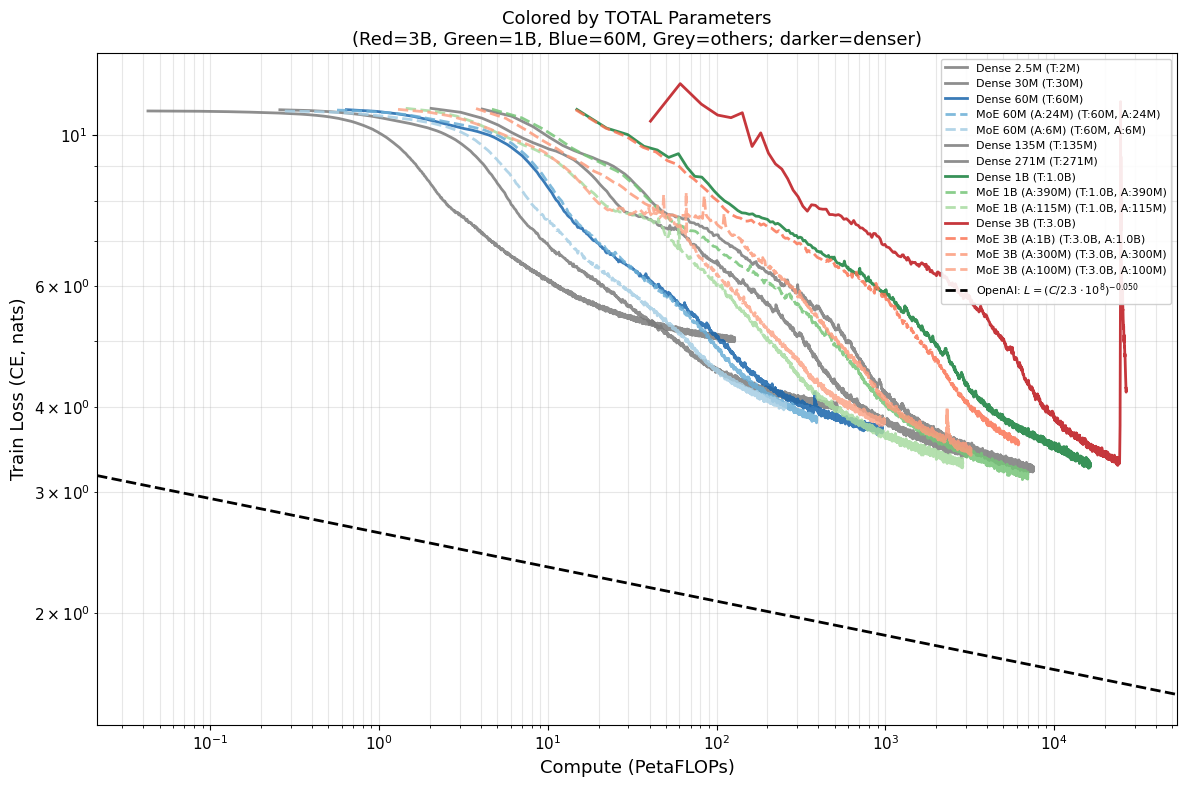

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

def sort_key_total(name):
    info = MODEL_INFO.get(name, {})
    return (info.get('total_params', 0), -get_sparsity(name))

sorted_models = sorted(model_data.keys(), key=sort_key_total)

for name in sorted_models:
    data = model_data[name]
    info = MODEL_INFO.get(name, {})
    total, active = info.get('total_params', 0), info.get('active_params', 0)
    is_moe = info.get('is_moe', False)
    
    label = f"{info.get('display_name', name)} (T:{format_params(total)}"
    if is_moe:
        label += f", A:{format_params(active)})"
    else:
        label += ")"
    
    linestyle = '--' if is_moe else '-'
    ax.plot(data['petaflops'], data['loss'], 
            color=get_color_by_total(name), alpha=0.85, linewidth=2,
            linestyle=linestyle, label=label)

ax.plot(pf_line, openai_scaling_law(pf_line), '--', color='black', linewidth=2, 
        label=r'OpenAI: $L = (C/2.3 \cdot 10^8)^{-0.050}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Compute (PetaFLOPs)')
ax.set_ylabel('Train Loss (CE, nats)')
ax.set_title('Colored by TOTAL Parameters\n(Red=3B, Green=1B, Blue=60M, Grey=others; darker=denser)')
ax.legend(loc='upper right', framealpha=0.9, fontsize=8)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(pf_min * 0.5, pf_extended_max)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/moe_analysis/plot1_by_total_params.png', dpi=150, bbox_inches='tight')
plt.show()

## Plot 2: Colored by ACTIVE Parameters

- **Red family**: ~300M active (3BA300M, 271M, 1BA390M)
- **Green family**: ~100-135M active (3BA100M, 135M, 1BA115M)
- **Blue family**: ~24-30M active (60MA24M, 30M)
- **Purple family**: ~2.5-6M active (2.5M, 60MA6M)

**Darker = Denser**

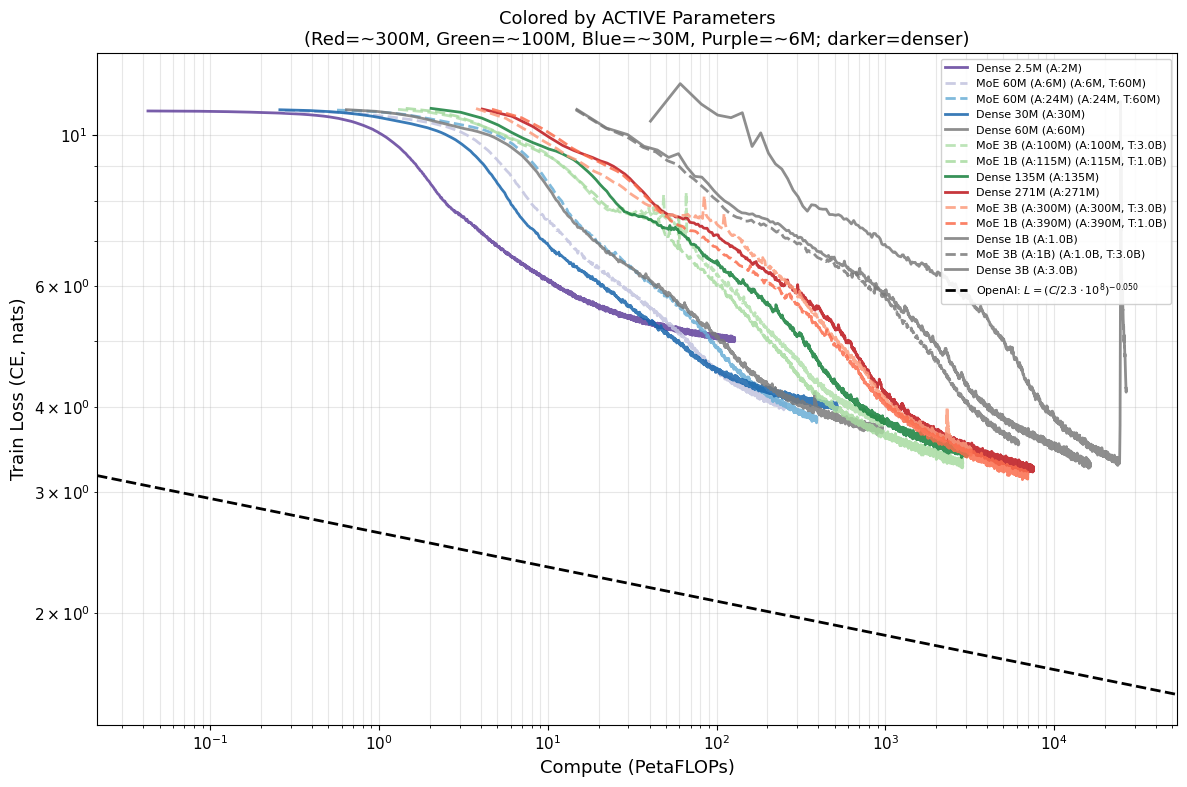

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

def sort_key_active(name):
    info = MODEL_INFO.get(name, {})
    return (info.get('active_params', 0), -get_sparsity(name))

sorted_models = sorted(model_data.keys(), key=sort_key_active)

for name in sorted_models:
    data = model_data[name]
    info = MODEL_INFO.get(name, {})
    total, active = info.get('total_params', 0), info.get('active_params', 0)
    is_moe = info.get('is_moe', False)
    
    label = f"{info.get('display_name', name)} (A:{format_params(active)}"
    if is_moe:
        label += f", T:{format_params(total)})"
    else:
        label += ")"
    
    linestyle = '--' if is_moe else '-'
    ax.plot(data['petaflops'], data['loss'], 
            color=get_color_by_active(name), alpha=0.85, linewidth=2,
            linestyle=linestyle, label=label)

ax.plot(pf_line, openai_scaling_law(pf_line), '--', color='black', linewidth=2, 
        label=r'OpenAI: $L = (C/2.3 \cdot 10^8)^{-0.050}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Compute (PetaFLOPs)')
ax.set_ylabel('Train Loss (CE, nats)')
ax.set_title('Colored by ACTIVE Parameters\n(Red=~300M, Green=~100M, Blue=~30M, Purple=~6M; darker=denser)')
ax.legend(loc='upper right', framealpha=0.9, fontsize=8)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(pf_min * 0.5, pf_extended_max)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/moe_analysis/plot2_by_active_params.png', dpi=150, bbox_inches='tight')
plt.show()

## Plot 3: MoE Models Only

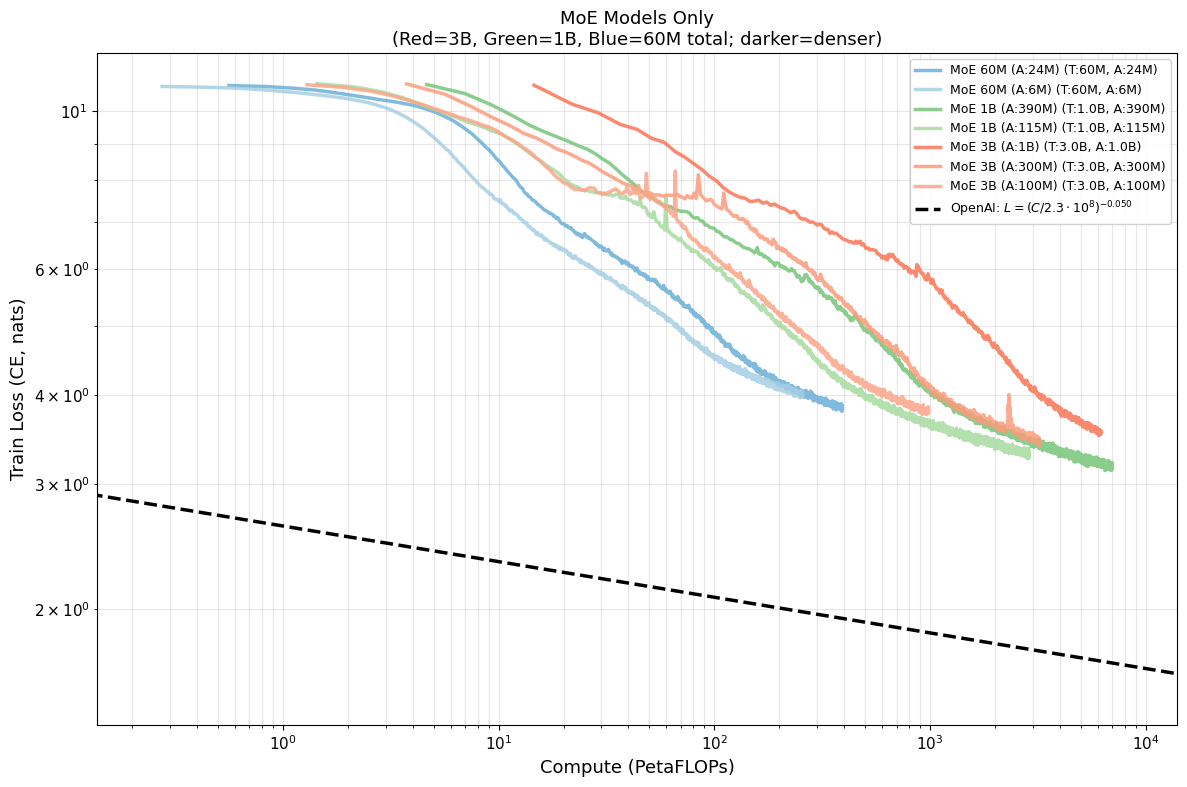

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

moe_models = [name for name in model_data.keys() if MODEL_INFO.get(name, {}).get('is_moe', False)]
moe_models = sorted(moe_models, key=sort_key_total)

for name in moe_models:
    data = model_data[name]
    info = MODEL_INFO.get(name, {})
    total, active = info.get('total_params', 0), info.get('active_params', 0)
    label = f"{info.get('display_name', name)} (T:{format_params(total)}, A:{format_params(active)})"
    ax.plot(data['petaflops'], data['loss'], 
            color=get_color_by_total(name), alpha=0.85, linewidth=2.5, label=label)

ax.plot(pf_line, openai_scaling_law(pf_line), '--', color='black', linewidth=2.5, 
        label=r'OpenAI: $L = (C/2.3 \cdot 10^8)^{-0.050}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Compute (PetaFLOPs)')
ax.set_ylabel('Train Loss (CE, nats)')
ax.set_title('MoE Models Only\n(Red=3B, Green=1B, Blue=60M total; darker=denser)')
ax.legend(loc='upper right', framealpha=0.9, fontsize=9)
ax.grid(True, alpha=0.3, which='both')

moe_pf = pd.concat([model_data[name]['petaflops'] for name in moe_models])
ax.set_xlim(moe_pf.min() * 0.5, moe_pf.max() * 2)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/moe_analysis/plot3_moe_only.png', dpi=150, bbox_inches='tight')
plt.show()

## Plot 4: Dense Frontier + MoE Overlay

- Dense models: Dark blue with black frontier line
- MoE colors:
  - **Dark red**: 1BA390M, 3BA1B (densest MoEs)
  - **Orange**: 1BA115M, 3BA300M
  - **Pink**: 3BA100M, 60M MoEs (sparsest)

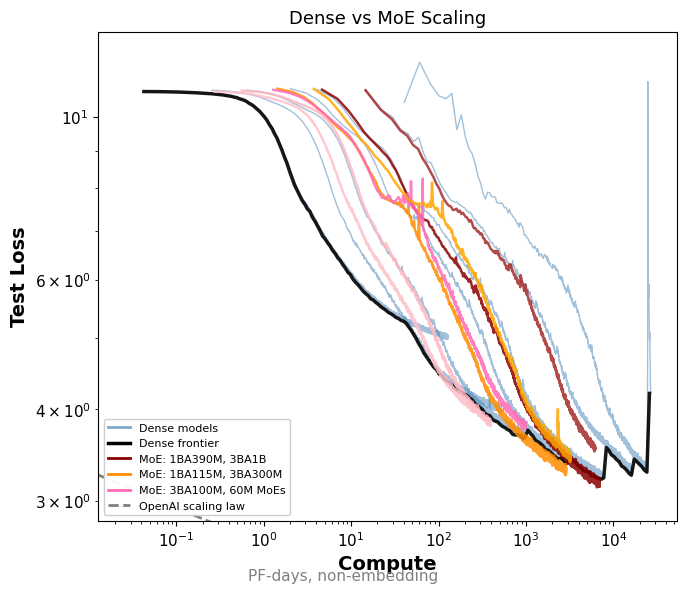

In [20]:
fig, ax = plt.subplots(figsize=(7, 6))

dense_models = [name for name in model_data.keys() if not MODEL_INFO.get(name, {}).get('is_moe', False)]
moe_models = [name for name in model_data.keys() if MODEL_INFO.get(name, {}).get('is_moe', False)]

# Plot dense models in dark blue
for name in dense_models:
    data = model_data[name]
    ax.plot(data['petaflops'], data['loss'], color='steelblue', alpha=0.5, linewidth=1)

# Dense frontier
dense_data = pd.concat([model_data[name].assign(model=name) for name in dense_models])
dense_data['pf_bin'] = pd.cut(np.log10(dense_data['petaflops']), bins=200)
frontier = dense_data.groupby('pf_bin').agg({'petaflops': 'mean', 'loss': 'min'}).dropna().sort_values('petaflops')
ax.plot(frontier['petaflops'], frontier['loss'], color='black', linewidth=2.5, alpha=0.9, label='Dense frontier')

# MoE colors based on sparsity category
# Dark red: 1BA390M, 3BA1B (densest MoEs, sparsity ~33-39%)
# Orange: 1BA115M, 3BA300M (medium, sparsity ~10-12%)
# Pink: 3BA100M, 60MA24M, 60MA6M (sparsest, sparsity ~3-40%)

MOE_COLORS = {
    'saturate_moe1Bolmo_15B': '#8B0000',      # Dark red - 1BA390M (39% density)
    'saturate_moe3BA1B_15B': '#A52A2A',       # Dark red - 3BA1B (33% density)
    'saturate_moe1Bsparse_15B': '#FF8C00',    # Orange - 1BA115M (11.5% density)
    'saturate_moe3BA300M_15B': '#FFA500',     # Orange - 3BA300M (10% density)
    'saturate_moe3BA100M_15B': '#FF69B4',     # Pink - 3BA100M (3.3% density)
    'saturate_moe60MA24M_15B': '#FFB6C1',     # Light pink - 60MA24M (40% density)
    'saturate_moe60MA6M_15B': '#FFC0CB',      # Lightest pink - 60MA6M (10% density)
}

for name in moe_models:
    data = model_data[name]
    color = MOE_COLORS.get(name, '#FF69B4')
    ax.plot(data['petaflops'], data['loss'], color=color, alpha=0.85, linewidth=1.8)

# OpenAI scaling law
pf_line_extended = np.logspace(np.log10(pf_min * 0.1), np.log10(pf_extended_max), 200)
ax.plot(pf_line_extended, openai_scaling_law(pf_line_extended), '--', color='gray', linewidth=2,
        label=r'$L = (C_{\min}/2.3 \cdot 10^8)^{-0.050}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(pf_min * 0.3, pf_extended_max)
all_losses = pd.concat([data['loss'] for data in model_data.values()])
ax.set_ylim(all_losses.min() * 0.9, all_losses.max() * 1.1)
ax.set_xlabel('Compute', fontsize=14, fontweight='bold')
ax.set_ylabel('Test Loss', fontsize=14, fontweight='bold')
ax.set_title('Dense vs MoE Scaling')

# Custom legend
legend_elements = [
    Line2D([0], [0], color='steelblue', linewidth=2, alpha=0.7, label='Dense models'),
    Line2D([0], [0], color='black', linewidth=2.5, label='Dense frontier'),
    Line2D([0], [0], color='#8B0000', linewidth=2, label='MoE: 1BA390M, 3BA1B'),
    Line2D([0], [0], color='#FF8C00', linewidth=2, label='MoE: 1BA115M, 3BA300M'),
    Line2D([0], [0], color='#FF69B4', linewidth=2, label='MoE: 3BA100M, 60M MoEs'),
    Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='OpenAI scaling law'),
]
ax.legend(handles=legend_elements, loc='lower left', framealpha=0.95, fontsize=8)

fig.text(0.5, 0.02, 'PF-days, non-embedding', ha='center', fontsize=11, color='gray')
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.savefig('/Users/timur/Desktop/Relace/wandb_friday/moe_analysis/plot4_dense_frontier_moe_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [21]:
print("=" * 70)
print("SUMMARY")
print("=" * 70)

for total_group in ['60M', '1B', '3B', 'other']:
    group_models = [name for name in model_data.keys() 
                    if MODEL_INFO.get(name, {}).get('total_group') == total_group]
    if not group_models: continue
    
    print(f"\n=== {total_group} Total Params ===")
    for name in sorted(group_models, key=lambda x: -get_sparsity(x)):
        info = MODEL_INFO.get(name, {})
        data = model_data[name]
        sparsity = get_sparsity(name)
        print(f"  {info.get('display_name', name)}: A={format_params(info.get('active_params', 0))}, density={sparsity:.1%}, final_loss={data['loss'].min():.3f}")

SUMMARY

=== 60M Total Params ===
  Dense 60M: A=60M, density=100.0%, final_loss=3.646
  MoE 60M (A:24M): A=24M, density=40.0%, final_loss=3.792
  MoE 60M (A:6M): A=6M, density=10.0%, final_loss=3.961

=== 1B Total Params ===
  Dense 1B: A=1.0B, density=100.0%, final_loss=3.253
  MoE 1B (A:390M): A=390M, density=39.0%, final_loss=3.132
  MoE 1B (A:115M): A=115M, density=11.5%, final_loss=3.253

=== 3B Total Params ===
  Dense 3B: A=3.0B, density=100.0%, final_loss=3.285
  MoE 3B (A:1B): A=1.0B, density=33.3%, final_loss=3.506
  MoE 3B (A:300M): A=300M, density=10.0%, final_loss=3.390
  MoE 3B (A:100M): A=100M, density=3.3%, final_loss=3.755

=== other Total Params ===
  Dense 135M: A=135M, density=100.0%, final_loss=3.373
  Dense 2.5M: A=2M, density=100.0%, final_loss=4.981
  Dense 30M: A=30M, density=100.0%, final_loss=3.955
  Dense 271M: A=271M, density=100.0%, final_loss=3.213
